## Coding Assignment 1

Team:
- Olivia Dalglish (od4)
- Arindam Saha (saha2)

Contribution: 

Olivia: Parts 1, 4 and 5

Arindam: Part 2, 3 and 5

In addition to the above, we discussed our approaches and checked each other's work.

### Part 1: Generate Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier as skl_knn


In [2]:
# Part 1.1

np.random.seed(10)

n_centers = 20
n_classes = 2 # 0 or 1
n_centers_per_class = n_centers // n_classes
variance = 1/5

centers = np.random.multivariate_normal([0, 0], np.eye(2), size=n_centers)

# We could do np.random.shuffle(centers) but centers are already generated randomly, so this is a random split into 2 classes
centers = np.split(centers, n_classes)

In [3]:
def generate_data_points(centers, n_samples, variance):
    n_samples_per_center = n_samples // len(centers)
    data = []
    for center in centers:
        samples = np.random.multivariate_normal(center, variance * np.eye(2), size=n_samples_per_center)
        data.append(samples)
    return np.vstack(data)

def generate_data_matrices(centers, sample_size):
    n_classes = len(centers)
    n_samples_per_class = sample_size // n_classes
    
    Xtrain = []
    Ytrain = []
    for target, class_centers in enumerate(centers):
        X = generate_data_points(class_centers, n_samples_per_class, variance)
        Y = [target] * X.shape[0]
        Xtrain.append(X)
        Ytrain.append(Y)
    
    Xtrain = np.vstack(Xtrain)
    Ytrain = np.concatenate(Ytrain)
    return Xtrain, Ytrain

Xtrain, Ytrain = generate_data_matrices(centers, 200)
Xtest, Ytest = generate_data_matrices(centers, 10000)

print(f"Xtrain: {Xtrain.shape}")
print(f"Ytrain: {Ytrain.shape}")
print(f"Xtest: {Xtest.shape}")
print(f"Ytest: {Ytest.shape}")

Xtrain: (200, 2)
Ytrain: (200,)
Xtest: (10000, 2)
Ytest: (10000,)


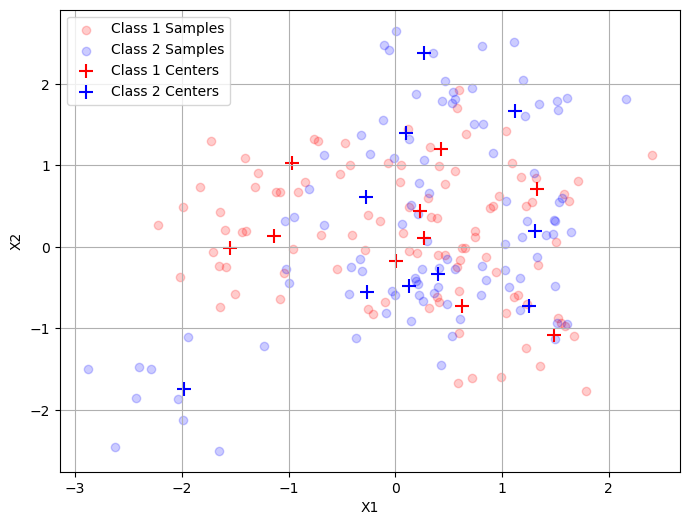

In [4]:
plt.figure(figsize=(8, 6))

plt.scatter(Xtrain[Ytrain == 0, 0], Xtrain[Ytrain == 0, 1], color='red', alpha=0.2, label='Class 1 Samples')
plt.scatter(Xtrain[Ytrain == 1, 0], Xtrain[Ytrain == 1, 1], color='blue', alpha=0.2, label='Class 2 Samples')

# Plot the centers with a '+' marker
plt.scatter(centers[0][:,0], centers[0][:,1], color='red', marker='+', s=100, label='Class 1 Centers')
plt.scatter(centers[1][:,0], centers[1][:,1], color='blue', marker='+', s=100, label='Class 2 Centers')

# Add legend and labels
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()


## Part 2

In [5]:
def knn(X_Y_train, X_test, k):
    X_train, Y_train = X_Y_train

    u = np.sum(X_train ** 2, axis=1)
    v = np.sum(X_test ** 2, axis=1)
    B = X_train @ X_test.T

    # Using formula from this post https://campuswire.com/c/GB46E5679/feed/45
    D = u[:, np.newaxis] - (2 * B) + v
    # D[i, j] is squared distance from i-th train point to j-th test point

    # Using stable sort, so equidistant points will get sorted in the order they appear in the data 
    sort_order = np.argsort(D, axis=0, kind='stable')
    Y_knn = np.take_along_axis(Y_train[:, np.newaxis], sort_order[:k, :], axis=0)
    
    counts = np.sum(Y_knn, axis=0)
    Y_test = (counts > k / 2).astype(int)
    # Breaking voting ties, by assigning it the label of the closest point
    Y_test[counts == k / 2] = Y_knn[0, counts == k / 2]

    return Y_test


Distance ties: We pick the training data that occurs first in the dataset (by using a stable sort)

Voting ties: We assign the class label of the closest point

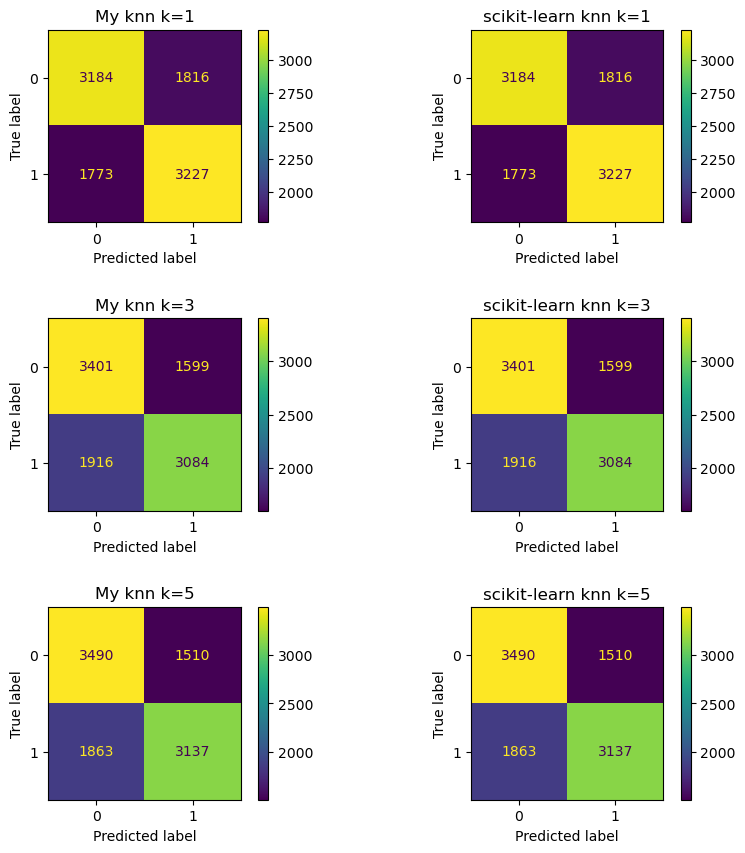

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

fig.subplots_adjust(hspace=0.5)

for k, ax in zip([1, 3, 5], axes):
    Ypred = knn((Xtrain, Ytrain), Xtest, k)
    confusion_matrix = metrics.confusion_matrix(Ytest, Ypred)
    cm_display = metrics.ConfusionMatrixDisplay.from_predictions(Ytest, Ypred, display_labels = [0, 1], ax=ax[0])
    ax[0].set_title(f'My knn k={k}')
    
    knn_model = skl_knn(n_neighbors=k)
    knn_model.fit(Xtrain, Ytrain)
    Ypred_skl = knn_model.predict(Xtest)
    cm_display = metrics.ConfusionMatrixDisplay.from_predictions(Ytest, Ypred_skl, display_labels = [0, 1], ax=ax[1])
    ax[1].set_title(f'scikit-learn knn k={k}')

plt.show()